# This script combines all of the crops from the department of agriculture into one massive file

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Modifications to make
- Year -> DNL Source Year
- Take first year of range and make it the 'Year' column (except maybe for summer? ask Gary)
- Remove numbers from State and District Columns
- State -> Admin 1 and District -> Admin 2 (with state initials in parentheses)
- Add start and end periods
    - Kharif = 6/1 - 9/30
    - Autumn = 9/1 - 10/31
    - Rabi = 10/1 - 1/31
    - Winter = 12/15 - 3/15
    - Summer = 3/15 - 5/31
    - Whole Year = self explanatory (but ask Gary about year)
- Add crop codes
- Add production style (all for everything)
- Crop -> Source Crop
- Area (hectare) -> Area Harvested: ha
- Yield (Tonne/ha) -> Yield: MT/ha
- Production (Tonnes) -> Quantity Produced: MT
- Area Planted = NA
- Data Source Organization = MoA & FW, India
- Data Source Document = Official agricultural statistics, India, crop
- Publication Name = https://data.desagri.gov.in/website/crops-apy-report-web, extracted Feb 2025, India
- Survey Type = crop_final
- Country = IN
- FNID = (leave blank for now I think)

In [2]:
#############################################################
# Read in the raw files and convert it to a pandas DataFrame
#############################################################
def read_file(filename):
    # Read the file as text
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(content, 'html.parser')
    table = soup.find('table')

    # Convert to pandas DataFrame
    df = pd.read_html(str(table))[0]

    # Clean up any potential messy data
    df = df.replace({r'\s+$': ''}, regex=True)  # Remove trailing whitespace
    df = df.replace({r'^\s+': ''}, regex=True)  # Remove leading whitespace

    return df

In [3]:
#############################################################
# Clean the DataFrame by removing rows with all NaN values and resetting the index
#############################################################
def restack(df):
    # Keep the first three columns as they are
    id_cols = df.iloc[:, :3].copy()  # State, District, Year
    id_cols.columns = ['State', 'District', 'Year']  # Flatten these column names

    # Get the measurement columns (everything except first three)
    measure_cols = df.iloc[:, 3:]

    # Stack only crop and season levels, keeping indicators as columns
    stacked = (measure_cols
        .stack(level=0, dropna=False)  # Stack first level (Crop)
        .stack(level=0, dropna=False)  # Stack second level (Season)
    )

    # Convert to DataFrame and reset index
    stacked_df = stacked.reset_index()

    # Rename the columns appropriately
    stacked_df = stacked_df.rename(columns={
        'level_1': 'Crop',
        'level_2': 'Season',
        0: 'Area (Hectare)',
        1: 'Production (Tonnes)',
        2: 'Yield (Tonne/Hectare)'
    })

    # Create final dataframe
    final_df = pd.concat([
        id_cols.loc[stacked_df['level_0']].reset_index(drop=True),
        stacked_df.drop('level_0', axis=1)
    ], axis=1)

    #Remove rows with all NaN values
    final_df = clean_df(final_df)

    # Sort the data
    final_df = final_df.sort_values(['State', 'District', 'Year', 'Crop', 'Season'])

    # Reset the index for clean output
    final_df = final_df.reset_index(drop=True)

    return final_df

In [4]:
#############################################################
# Clean the DataFrame by removing rows with all NaN values
# and keeping only rows where at least one of Area, Production, or Yield is not NaN
#############################################################
def clean_df(df):
    # Remove rows where all values are missing
    # Keep only rows where at least one of Area, Production, or Yield is not NaN
    df = df.dropna(
        subset=['Area (Hectare)', 'Production (Tonnes)', 'Yield (Tonne/Hectare)'],
        how='all'
    )

    return df

In [5]:
#############################################################
# Add state abbreviations to the District column
#############################################################
def add_state_abbr(final_df):
    #Add state abbreviations
    abbr_map = {
    'Andhra Pradesh': '(AP)',
    'Arunachal Pradesh': '(AR)',
    'Assam': '(AS)',
    'Bihar': '(BR)',
    'Chhattisgarh': '(CG)',
    'Goa': '(GA)',
    'Gujarat': '(GJ)',
    'Haryana': '(HR)',
    'Himachal Pradesh': '(HP)',
    'Jharkhand': '(JH)',
    'Jammu and Kashmir': '(JK)',
    'Karnataka': '(KA)',
    'Kerala': '(KL)',
    'Madhya Pradesh': '(MP)',
    'Maharashtra': '(MH)',
    'Manipur': '(MN)',
    'Meghalaya': '(ML)',
    'Mizoram': '(MZ)',
    'Nagaland': '(NL)',
    'Odisha': '(OD)',
    'Punjab': '(PB)',
    'Rajasthan': '(RJ)',
    'Sikkim': '(SK)',
    'Tamil Nadu': '(TN)',
    'Telangana': '(TG)',
    'Tripura': '(TR)',
    'Uttar Pradesh': '(UP)',
    'Uttarakhand': '(UK)',
    'West Bengal': '(WB)',
    'Andaman and Nicobar Islands': '(AN)',
    'Chandigarh': '(CH)',
    'The Dadra & Nagar Haveli and Daman and Diu': '(DD)',
    'The Dadra and Nagar Haveli and Daman and Diu': '(DD)',
    'Dadra and Nagar Haveli and Daman and Diu': '(DD)',
    'Dadra and Nagar Haveli': '(DN)',
    'Daman and Diu': '(DA)',
    'Delhi': '(DL)',
    'Ladakh': '(LA)',
    'Lakshadweep': '(LD)',
    'Puducherry': '(PY)'
    }

    final_df['District'] = final_df['District'] + ' ' + final_df['State'].map(abbr_map)

    return final_df

In [6]:
#############################################################
# Add in the dates for each season 
#############################################################
def get_period_dates(row):
    #Add in season information
    # Kharif = 6/1 - 9/30
    # - Autumn = 9/1 - 10/31
    # - Rabi = 10/1 - 1/31 #must go to next year for Rabi
    # - Winter = 12/15 - 3/15
    # - Summer = 3/15 - 5/31
    season_dates = {
        'Summer': {'start_month': 3, 'start_day': 15, 'end_month': 5, 'end_day': 31},
        'Winter': {'start_month': 12, 'start_day': 15, 'end_month': 3, 'end_day': 15},  # example
        'Rabi': {'start_month': 10, 'start_day': 1, 'end_month': 1, 'end_day': 31},    # example
        'Kharif': {'start_month': 6, 'start_day': 1, 'end_month': 9, 'end_day': 30},   # example
        'Autumn': {'start_month': 9, 'start_day': 1, 'end_month': 10, 'end_day': 31},  # example
        'Whole Year': {'start_month': 1, 'start_day': 1, 'end_month': 12, 'end_day': 31}
    }

    year = int(row['Year'])
    season = row['Season'].strip().title()
    
    season_info = season_dates[season]
    
    start_date = pd.Timestamp(
        year=year,
        month=season_info['start_month'],
        day=season_info['start_day']
    ).strftime('%-m/%-d/%Y')  # formats as m/d/yyyy without leading zeros
    
    end_year = year + 1 if season in ('Winter', 'Rabi') and season_info['end_month'] < season_info['start_month'] else year
    
    end_date = pd.Timestamp(
        year=end_year,
        month=season_info['end_month'],
        day=season_info['end_day']
    ).strftime('%-m/%-d/%Y')
    
    return pd.Series({'Start Period': start_date, 'End Period': end_date})


In [7]:
#############################################################
# Clean season information and add start and end dates
#############################################################
def add_season(final_df):
    # Convert Year to integer, handling any potential issues
    final_df['Year'] = pd.to_numeric(final_df['Year'], errors='coerce')

    # Clean up Season column - strip whitespace and convert to lowercase
    final_df['Season'] = final_df['Season'].str.strip().str.title()

    final_df[['Start Period', 'End Period']] = final_df.apply(get_period_dates, axis=1)

    return final_df

In [8]:
#########################################################################################
# Fix district names by changing ag stats names to match the names in the hybrid boundary
#########################################################################################
def district_fix(final_df):
    district_mapping = {
    # Format: 'Old name': 'New name'
    '24 Paraganas North (WB)': 'North Twenty-Four Paraganas (WB)',
    '24 Paraganas South (WB)': 'South Twenty-Four Paraganas (WB)',
    '24 paraganas north (WB)': 'North Twenty-Four Paraganas (WB)',
    '24 paraganas south (WB)': 'South Twenty-Four Paraganas (WB)',
    'Ahmadabad (GJ)': 'Ahmedabad (GJ)',
    'Allahabad (UP)': 'Prayagraj (UP)',
    'Anugul (OD)': 'Angul (OD)',
    'Baghpat (UP)': 'Bagpat (UP)',
    'Bellary (KA)': 'Ballari (KA)',
    'Badgam (JK)': 'Budgam (JK)',
    'Baleshwar (OD)': 'Balasore (OD)',
    'Balrampur (CG)': 'Balrampur-Ramanujganj (CG)',
    'Bandipora (JK)': 'Bandipore (JK)',
    'Banas Kantha (GJ)': 'Banaskantha (GJ)',
    'Banas kantha (GJ)': 'Banaskantha (GJ)',
    'Bangalore Rural (KA)': 'Bengaluru Rural (KA)',
    'Barabanki (UP)': 'Bara Banki (UP)',
    'Baramulla (JK)': 'Baramula (JK)',
    'Belgaum (KA)': 'Belagavi (KA)',
    'Bhadradri (TG)': 'Bhadradri Kothagudem (TG)',
    'Charki Dadri (HR)': 'Charkhi Dadri (HR)',
    'Chhotaudepur (GJ)': 'Chhota Udaipur (GJ)',
    'Coochbehar (WB)': 'Koch Bihar (WB)',
    'Dakshin Kannad (KA)': 'Dakshina Kannada (KA)',
    'Dang (GJ)': 'Dangs (GJ)',
    'Davangere (KA)': 'Davanagere (KA)',
    'Deogarh (OD)': 'Debagarh (OD)',
    'Devbhumi dwarka (GJ)': 'Devbhumi Dwarka (GJ)',
    'Dinajpur Dakshin (WB)': 'Dakshin Dinajpur (WB)',
    'Dinajpur Uttar (WB)': 'Uttar Dinajpur (WB)',
    'Dohad (GJ)': 'Dahod (GJ)',
    'East Singhbum (JH)': 'Purba Singhbhum (JH)',
    'Faizabad (UP)': 'Ayodhya (UP)',
    'Firozepur (PB)': 'Firozpur (PB)',
    'Ganganagar (RJ)': 'Sri Ganganagar (RJ)',
    'Gariyaband (CG)': 'Gariaband (CG)',
    'Geyzing (SK)': 'Gyalshing (SK)',
    'Gondia (MH)': 'Gondiya (MH)',
    'Gulbarga (KA)': 'Kalaburagi (KA)',
    'Jagatsinghapur (OD)': 'Jagatsinghpur (OD)',
    'Jagitial (TG)': 'Jagtial (TG)',
    'Jajapur (OD)': 'Jajpur (OD)',
    'Jangoan (TG)': 'Jangaon (TG)',
    'Jayashankar (TG)': 'Jayashankar Bhupalpally (TG)',
    'Jogulamba (TG)': 'Jogulamba Gadwal (TG)',
    'Kadapa (AP)': 'YSR Kadapa (AP)',
    'Kaimur (Bhabua) (BR)': 'Kaimur (BR)',
    'Kamrup Rural (AS)': 'Kamrup (AS)',
    'Kamrup Metro (AS)': 'Kamrup Metropolitan (AS)',
    'Kanniyakumari (TN)': 'Kanyakumari (TN)',
    'Kanpur nagar (UP)': 'Kanpur Nagar (UP)',
    'Kasaragod (KL)': 'Kasargod (KL)',
    'Khairgarh Chhuikhadan Gandai (CG)': 'Khairagarh (CG)',
    'Kheri (UP)': 'Lakhimpur Kheri (UP)',
    'Komaram Bheem Asifabad (TG)': 'Kumuram Bheem Asifabad (TG)',
    'Korea (CG)': 'Koriya (CG)',
    'Kushi Nagar (UP)': 'Kushinagar (UP)',
    'Lahul And Spiti (HP)': 'Lahaul and Spiti (HP)',
    'Lahul and spiti (HP)': 'Lahaul and Spiti (HP)',
    'Leh Ladakh (LA)': 'Leh (LA)',
    'Leh Ladakh (JK)': 'Leh (LA)',
    'Leparada (AR)': 'Lepa Rada (AR)',
    'Maldah (WB)': 'Malda (WB)',
    'Manendragarh Chirimiri Bharatpur (CG)': 'Manendragarh (CG)',
    'Medchal (TG)': 'Medchal-Malkajgiri (TG)',
    'Medinipur East (WB)': 'Purba Medinipur (WB)',
    'Medinipur West (WB)': 'Paschim Medinipur (WB)',
    'Mewat (HR)': 'Nuh (HR)',
    'Mohla Manpur Ambagarh Chouki (CG)': 'Mohla-Manpur (CG)',
    'Muktsar (PB)': 'Sri Muktsar Sahib (PB)',
    'Mumbai (MH)': 'Mumbai City (MH)',
    'Mumbai suburban (MH)': 'Mumbai Suburban (MH)',
    'Muzaffarpur (BR)': 'Muzzafarpur (BR)',
    'Narayanapet (TG)': 'Narayanpet (TG)',
    'Nawanshahr (PB)': 'Shahid Bhagat Singh Nagar (PB)',
    'North And Middle Andaman (AN)': 'North and Middle Andaman (AN)',
    'North Twenty-four Paraganas (WB)': 'North Twenty-Four Parganas (WB)',
    'Ntr (AP)': 'NT Rama Rao (AP)',
    'Nuiland (NL)': 'Niuland (NL)',
    'Pakke Kessang (AR)': 'Pakke Kesang (AR)',
    'Panch Mahals (GJ)': 'Panchmahal (GJ)',
    'Pashchim Champaran (BR)': 'Paschim Champaran (BR)',
    'Pondicherry (PY)': 'Puducherry (PY)',
    'Purbi Champaran (BR)': 'Purba Champaran (BR)',
    'Rae Bareli (UP)': 'Raebareli (UP)',
    'Rajanna (TG)': 'Rajanna Sircilla (TG)',
    'Rajauri (JK)': 'Rajouri (JK)',
    'Rangareddi (TG)': 'Ranga Reddy (TG)',
    'Ri Bhoi (ML)': 'Ri-Bhoi (ML)',
    'S.A.S Nagar (PB)': 'Sahibzada Ajit Singh Nagar (PB)',
    'Sabar Kantha (GJ)': 'Sabarkantha (GJ)',
    'Sahebganj (JH)': 'Sahibganj (JH)',
    'Siaha (MZ)': 'Saiha (MZ)',
    'Sakti (CG)': 'Shakti (CG)',
    'Sant Kabeer Nagar (UP)': 'Sant Kabir Nagar (UP)',
    'Sant Ravidas Nagar (UP)': 'Bhadohi (UP)',
    'Saraikela Kharsawan (JH)': 'Seraikela Kharsawan (JH)',
    'Sarangarh Bilaigarh (CG)': 'Sarangarh-Bilaigarh (CG)',
    'Sepahijala (TR)': 'Sipahijala (TR)',
    'Shimoga (KA)': 'Shivamogga (KA)',
    'Siaha (MZ)': 'Saiha (MZ)',
    'Siddharth nagar (UP)': 'Siddharth Nagar (UP)',
    'Sonepur (OD)': 'Subarnapur (OD)',
    'South Salmara Mancachar (AS)': 'South Salmara-Mankachar (AS)',
    'South Twenty-four Paraganas (WB)': 'South Twenty-Four Parganas (WB)',
    'Spsr Nellore (AP)': 'Nellore (AP)',
    'The Nilgiris (TN)': 'Nilgiris (TN)',
    'Thenkasi (TN)': 'Tenkasi (TN)',
    'Thiruvallur (TN)': 'Tiruvallur (TN)',
    'Tirupathur (TN)': 'Tirupattur (TN)',
    'Udam Singh Nagar (UK)': 'Udham Singh Nagar (UK)',
    'Uttar Kashi (UK)': 'Uttarkashi (UK)',
    'Vijayanagar (KA)': 'Vijayanagara (KA)',
    'Visakhapatanam (AP)': 'Visakhapatnam (AP)',
    'West Singhbhum (JH)': 'Paschim Singhbhum (JH)',
    'West karbi anglong (AS)': 'West Karbi Anglong (AS)',
    'Yadadri (TG)': 'Yadadri Bhuvanagiri (TG)',
    'Yadgir (KA)': 'Yadagiri (KA)',
    'Yamunanagar (HR)': 'Yamuna Nagar (HR)',
    'nan': 'NA'
    }
    
    final_df['District'] = final_df['District'].replace(district_mapping)

    return final_df

In [9]:
#############################################################
# Rename the Area, Yield, and Production columns
# Fix numbers in state and district columns
# Add state abbreviations
# Change district names to common spellings from Gary's file
# Add in FEWS metadata
# Establish source year column
# Rename state and district columns
# Add in season information
# Convert types in main dataframe
#############################################################

def renaming(final_df):
    #First we rename the Area, Yield, and Production columns
    final_df.rename(columns={'Area (Hectare)': 'Area Harvested: ha', 'Production (Tonnes)': 'Quantity Produced: MT', 'Yield (Tonne/Hectare)': 'Yield: MT/ha'}, inplace=True)

    #Fix numbers in state and district columns
    final_df['State'] = final_df['State'].str.split('.', n=1).str[1].str.strip()
    final_df['District'] = final_df['District'].str.split('.', n=1).str[1].str.strip()
    final_df['District'] = final_df['District'].str.title()

    #Add state abbreviations
    final_df = add_state_abbr(final_df)

    #Change district names to common spellings from Gary's file
    final_df = district_fix(final_df)

    print(np.sort(final_df['District'].unique().astype(str)))

    #Establish source year column
    final_df['DNL_Source_year'] = final_df['Year'].str.replace(' ','')
    final_df['DNL_Source_year'] = final_df['DNL_Source_year'].apply(lambda s: s[:4] + '-' + s[-2:])
    final_df['Year'] = final_df['Year'].str.split('-', n=1).str[0].str.strip()

    #Rename state and district columns
    final_df.rename(columns={'State': 'Admin 1', 'District': 'Admin 2'}, inplace=True)

    #Add in FEWS metadata
    final_df['Admin 3'] = ''
    final_df['Country'] = 'IN'
    final_df['Survey Type'] ='crop_final'
    final_df['Data Source Organization'] = 'MoA & FW, India'
    final_df['Data Source Document'] = 'Official agricultural statistics, India, crop'
    final_df['Publication Name'] = 'https://data.desagri.gov.in/website/crops-apy-report-web, extracted Feburary 2025, India'
    final_df['FNID'] = ''
    final_df['Dominant Production System'] = 'All (PS)'
    final_df['Area Planted: ha'] = 'NA'
    final_df['Contributions by'] = 'Harvard'
    final_df['Start Period'] = ''
    final_df['End Period'] = ''
    final_df['Zone'] = ''

    #Rename crop columns
    final_df.rename(columns={'Crop': 'Source crop'}, inplace=True)
    final_df['Crop'] = ''
    
    #Reorder columns
    final_df = final_df.loc[:, ['Data Source Organization', 'Data Source Document', 'Publication Name',
    'Survey Type', 'Country', 'Zone', 'FNID', 'Admin 1', 'Admin 2', 'Admin 3', 'Year', 'Start Period', 'Season', 'End Period',
    'Crop', 'Dominant Production System', 'Area Planted: ha', 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT', 
    'Contributions by', 'Source crop', 'DNL_Source_year']]

    #Add in season information
    final_df = add_season(final_df)

    # Convert types in main dataframe
    final_df['Area Harvested: ha'] = pd.to_numeric(final_df['Area Harvested: ha'], errors='coerce').round(2)
    final_df['Yield: MT/ha'] = pd.to_numeric(final_df['Yield: MT/ha'], errors='coerce').round(2)
    final_df['Quantity Produced: MT'] = pd.to_numeric(final_df['Quantity Produced: MT'], errors='coerce').round(2)

    return final_df

In [10]:
#############################################################
# Check for overlap between Gary's old file and the final DataFrame
#############################################################
def overlap_check(old_df, final_df):
    # Check for overlap
    check_columns = ['Admin 1', 'Admin 2', 'Year', 'Source crop', 'Season']
    
    # Convert year in test dataframe (already float for others)
    old_df['Year'] = old_df['Year'].astype(int)
    old_df['Area Harvested: ha'] = pd.to_numeric(old_df['Area Harvested: ha'], errors='coerce').round(2)
    old_df['Yield: MT/ha'] = pd.to_numeric(old_df['Yield: MT/ha'], errors='coerce').round(2)
    old_df['Quantity Produced: MT'] = pd.to_numeric(old_df['Quantity Produced: MT'], errors='coerce').round(2)

    # Now try the merge
    matches = final_df.merge(
        old_df, 
        on=check_columns,
        indicator=True,
        how='left'
    )

    # Count matches and non-matches
    match_stats = matches['_merge'].value_counts()

    print("\nResults:")
    print(f"Total rows in test dataset: {len(final_df)}")
    print(f"Number of matching rows: {sum(matches['_merge'] == 'both')}")
    print(f"Number of non-matching rows: {sum(matches['_merge'] == 'left_only')}")
    print(f"Percentage of test rows found in main dataset: {(sum(matches['_merge'] == 'both') / len(final_df)) * 100:.2f}%")

In [11]:
#############################################################
# Merge two DataFrames, keeping the last occurrence of duplicates based on specific columns
#############################################################
def merge_tables(old_df, final_df):
    # First, let's create a list of columns to check for duplicates
    check_columns = ['Admin 1', 'Admin 2', 'Year', 'Source crop', 'Season']
                    # 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT']
                    #Decided not to check on data because I noticed some discrepancies. My numbers seem more accurate, so we will only take mine.
    
    #Combine and drop duplicates that match in that subset
    combined_df = pd.concat([old_df, final_df], ignore_index=True)

    #Keep the last occurrence of duplicates based on the check_columns
    #This will keep the most recent data for each district, crop, and season combination
    combined_df = combined_df.drop_duplicates(subset=check_columns, keep='last')

    # Check for rows where all values are zero
    cols = ['Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT']
    good_rows = combined_df[cols].ne(0).any(axis=1)

    #Filter rows
    combined_df = combined_df[good_rows]

    return combined_df

# Now we do a quick check of Gary's data

In [12]:
#Load in full data and see how much overlap there is
old_df = pd.read_excel('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/old_agstats/IN_AgStatsFeb2025_Gary.xlsx') 

In [13]:
old_df

,Data Source Organization,Data Source Document,Publication Name,Survey Type,Country,Zone,FNID,Admin 1,Admin 2,Admin 3,...,Crop,Dominant Production System,Area Planted: ha,Area Harvested: ha,Yield: MT/ha,Quantity Produced: MT,Contributions by,Source crop,DNL_Source_year,Unnamed: 23
0,"MoA & FW, India","Official agricultural statistics, India, crop","https://aps.dac.gov.in, September, 2024, India",crop_final,IN,NaN,IN2000A20101,Andaman and Nicobar,Andaman (AN),,...,R01132AA,All (PS),NaN,10779,2.956026,31863,NaN,Rice,2000-01,NaN
1,"MoA & FW, India","Official agricultural statistics, India, crop","https://aps.dac.gov.in, September, 2024, India",crop_final,IN,NaN,IN2006A20104,Andaman and Nicobar,South Andamans (AN),,...,R01132AA,All (PS),NaN,10695.8,2.954524,31601,NaN,Rice,2002-03,NaN
2,"MoA & FW, India","Official agricultural statistics, India, crop","https://aps.dac.gov.in, September, 2024, India",crop_final,IN,NaN,IN2006A20104,Andaman and Nicobar,South Andamans (AN),,...,R01132AA,All (PS),NaN,10681.98,2.726086,29120,NaN,Rice,2004-05,NaN
3,"MoA & FW, India","Official agricultural statistics, India, crop","https://aps.dac.gov.in, September, 2024, India",crop_final,IN,NaN,IN2006A20104,Andaman and Nicobar,South Andamans (AN),,...,R01132AA,All (PS),NaN,10509.37,2.927007,30761,NaN,Rice,2003-04,NaN
4,"MoA & FW, India","Official agricultural statistics, India, crop","https://aps.dac.gov.in, September, 2024, India",crop_final,IN,NaN,IN2001A20101,Andaman and Nicobar,Andaman (AN),,...,R01132AA,All (PS),NaN,9718,2.781745,27033,NaN,Rice,2001-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583803,"MoA & FW, India","Official agricultural statistics, India, crop",https://data.desagri.gov.in/website/crops-apy-...,crop_final,IN,NaN,IN2022A23420,West Bengal,Uttar Dinajpur (WB),,...,R01510AA,All (PS),NaN,0,0,0,NaN,Potato,2022-23,NaN
583804,"MoA & FW, India","Official agricultural statistics, India, crop",https://data.desagri.gov.in/website/crops-apy-...,crop_final,IN,NaN,IN2022A23420,West Bengal,Uttar Dinajpur (WB),,...,R01703AC,All (PS),NaN,0,0,0,NaN,Horse-gram,2022-23,NaN
583805,"MoA & FW, India","Official agricultural statistics, India, crop",https://data.desagri.gov.in/website/crops-apy-...,crop_final,IN,NaN,IN2022A23420,West Bengal,Uttar Dinajpur (WB),,...,R01708AA,All (PS),NaN,0,0,0,NaN,Moong(Green Gram),2022-23,NaN
583806,"MoA & FW, India","Official agricultural statistics, India, crop",https://data.desagri.gov.in/website/crops-apy-...,crop_final,IN,NaN,IN2022A23420,West Bengal,Uttar Dinajpur (WB),,...,R01709AQ,All (PS),NaN,0,0,0,NaN,Urad,2022-23,NaN


In [14]:
old_df[old_df['Year'] >= 2020]['Quantity Produced: MT'].value_counts()

Quantity Produced: MT
0.00        191379
1.00          1069
2.00           806
3.00           609
4.00           520
             ...  
1.35             1
17651.94         1
14508.70         1
10466.00         1
2327.00          1
Name: count, Length: 15614, dtype: int64

In [15]:
old_df['Source crop'].unique()

array(['Rice', 'Arecanut', 'Moong (Green Gram)', 'Urad',
       'Other Kharif pulses', 'Black pepper', 'Cowpea(Lobia)',
       'Dry chillies', 'Arhar/Tur', 'Maize', 'Sugarcane',
       'Moong(Green Gram)', 'Sweet potato', 'Dry Ginger', 'Ginger',
       'Turmeric', 'Sesamum', 'Groundnut', 'Rapeseed/Mustardseed',
       'Cashewnut', 'Sunflower', 'Safflower', 'Rapeseed &Mustard',
       'Jowar', 'Ragi', 'Small millets', 'Jute', 'Wheat', 'Barley',
       'Bajra', 'Garlic', 'Onion', 'Banana', 'Soyabean', 'Niger seed',
       'Castor seed', 'Potato', 'Tapioca', 'Coriander',
       'Peas & beans (Pulses)', 'Gram', 'Horse-gram', 'Masoor',
       'Guar seed', 'Moth', 'Cotton(lint)', 'Mesta', 'Sannhamp',
       'Tobacco', 'Linseed', 'Khesari', 'Other Rabi pulses',
       'dry chillies', 'Soybean', 'Castor', 'Chickpea', 'Cotton',
       'Vegetables', 'Fodder', 'Pigeonpea', 'Rapeseed And Mustard',
       'Potatoes', 'Sunflower seed', 'Pineapple', 'Sorghum',
       'Finger Millet', 'Pearl Millet', 

# Grab all of the files for processing and merging

In [16]:
#Grab all files in the directory except the banana one which we already did
os.chdir('/Users/michaelfoley/Google Drive/My Drive/Subnational_Yield_Database/data/raw/IND/')

all_files = glob.glob('*.xls')
#new_files = list(filter(lambda x: 'banana' not in x, all_files))

In [17]:
#Loop through all of the files and stack them together. Save the output to a new file
#that is named based on the crops we are currently processing. The final one is
#rapeseed_nigerseed_sesamum_groundnut
i =0
for file in all_files:
    current_crops = file.split('.')[0].split('/')[-1]
    print(f'\nWorking on {current_crops}')

    #Read in
    df = read_file(file)
    final_df = restack(df)
    final_df = renaming(final_df)

    #Check for overlap
    overlap_check(old_df, final_df)

    #Merge
    if i != 0:
        old_df = merge_tables(old_df, final_df)
    else:
        old_df = final_df

    #Save
    old_df.to_csv(f'/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/scripts/country/IND/ag_save_{current_crops}_072425.csv',
    index=False)
    i += 1


Working on ragi_barley_wheat_smallmillets


/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Ban

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ajmer (RJ)' 'Alappuzha (KL)' 'Aligarh (UP)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amreli (GJ)' 'Amroha (UP)'
 'Anakapalli (AP)' 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)'
 'Angul (OD)' 'Anjaw (AR)' 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Ayodhya (UP)' 'Azamgarh (UP)' 'Bagalkot (KA)'
 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)'
 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)'
 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)' 'Balrampur (UP)'
 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)'
 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)'
 'Baramula (JK)' 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)'
 'Barpeta (AS)' 'Barwani (MP)' 'Bastar (CG)' 'Begusarai (BR)'
 'B

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Ban

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agra (UP)' 'Ahmedabad (GJ)' 'Aizawl (MZ)' 'Ajmer (RJ)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Amreli (GJ)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Annamayya (AP)'
 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)' 'Arwal (BR)'
 'Ashoknagar (MP)' 'Aurangabad (BR)' 'Bagalkot (KA)' 'Bageshwar (UK)'
 'Bahraich (UP)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Banki (UP)' 'Baramula (JK)' 'Baran (RJ)'
 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)' 'Barwani (MP)' 'Bastar (CG)'
 'Bathinda (PB)' 'Begusarai (BR)' 'Belagavi (KA)' 'Bemetara (CG)'
 'Bengaluru Rural (KA)' 'Bengaluru Urban (KA)'

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anand (GJ)' 'Anantapur (AP)'
 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)' 'Annamayya (AP)' 'Anuppur (MP)'
 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)' 'Arwal (BR)'
 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)' 'Aurangabad (MH)'
 'Ayodhya (UP)' 'Azamgarh (UP)' 'Bagalkot (KA)' 'Bageshwar (UK)'
 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)'
 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)'
 'Baloda Bazar (CG)' 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)'
 'Banaskantha (GJ)' 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)'
 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)'
 'Baramula (JK)' 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (O

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Alluri Sitharama Raju (AP)'
 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Angul (OD)' 'Anjaw (AR)' 'Annamayya (AP)'
 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)' 'Arwal (BR)'
 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)' 'Aurangabad (MH)'
 'Azamgarh (UP)' 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)'
 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)'
 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)'
 'Baloda Bazar (CG)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)'
 'Bara Banki (UP)' 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)'
 'Barmer (RJ)' 'Barnala (PB)' 'Barpeta (AS)' 'Barwani (MP)' 'Bastar

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Ban

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Aizawl (MZ)' 'Ajmer (RJ)' 'Alappuzha (KL)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Alluri Sitharama Raju (AP)'
 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)' 'Ambedkar Nagar (UP)'
 'Amethi (UP)' 'Amreli (GJ)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anuppur (MP)'
 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)' 'Arwal (BR)'
 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)' 'Ayodhya (UP)'
 'Azamgarh (UP)' 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)'
 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)'
 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)'
 'Bara Banki (UP)' 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)'
 'Barmer (RJ)' 'Barpeta (AS)' 'Barwani (MP)' 'Bastar (CG)' 'Basti (UP)'
 'Begusarai (BR)' 

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Ariyalur (TN)'
 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)'
 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)' 'Bagalkot (KA)'
 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)'
 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)'
 'Baloda Bazar (CG)' 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)'
 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)'
 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)' 'Baran (RJ)'
 'Bareilly (UP)' 'Bargarh (OD)' 'Barnala (P

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Ajmer (RJ)' 'Akola (MH)' 'Alappuzha (KL)'
 'Aligarh (UP)' 'Alirajpur (MP)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)' 'Anantapur (AP)'
 'Angul (OD)' 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)'
 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)'
 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)' 'Balrampur (UP)'
 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)'
 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)'
 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)' 'Barpeta (AS)'
 'Barwani (MP)' 'Bastar (CG)' 'Basti (UP)' 'Beed (MH)' 'Begusarai (BR)'
 'Belagavi (KA)' '

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Ban

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/477275936.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_21401/4023127196.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation an

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipore (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Ban

# Copy Over the Final File to the Processed Directory

In [21]:
os.chdir('/Users/michaelfoley/Documents/Old_Documents/Climate/Crops/india_hybrid_methodology/mike/hybrid_production/')

In [22]:
# Now we copy over the final file to the processed data directory
import shutil
shutil.copyfile('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/scripts/country/IND/ag_save_rapeseed_nigerseed_sesamum_groundnut_072425.csv',
'/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_072425.csv')

shutil.copyfile('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_072425.csv',
                '../../data/ag_stats_final_072425.csv')

'../../data/ag_stats_final_072425.csv'

# Check for Overlap [MOVE TO DIFFERENT FILE]

(array([ 9445.,  9516.,  9786.,  9783.,  9881., 10132., 10325., 13681.,
        15627.,  9461.,  9897.,  9790., 10267., 10486., 10280., 10404.,
        10846., 11048., 11392., 10926., 11975., 12597., 12648., 13112.,
        13052., 13400., 14312., 14859., 14995., 16079., 67504., 68367.,
        97935.]),
 array([1990.        , 1990.96969697, 1991.93939394, 1992.90909091,
        1993.87878788, 1994.84848485, 1995.81818182, 1996.78787879,
        1997.75757576, 1998.72727273, 1999.6969697 , 2000.66666667,
        2001.63636364, 2002.60606061, 2003.57575758, 2004.54545455,
        2005.51515152, 2006.48484848, 2007.45454545, 2008.42424242,
        2009.39393939, 2010.36363636, 2011.33333333, 2012.3030303 ,
        2013.27272727, 2014.24242424, 2015.21212121, 2016.18181818,
        2017.15151515, 2018.12121212, 2019.09090909, 2020.06060606,
        2021.03030303, 2022.        ]),
 <BarContainer object of 33 artists>)

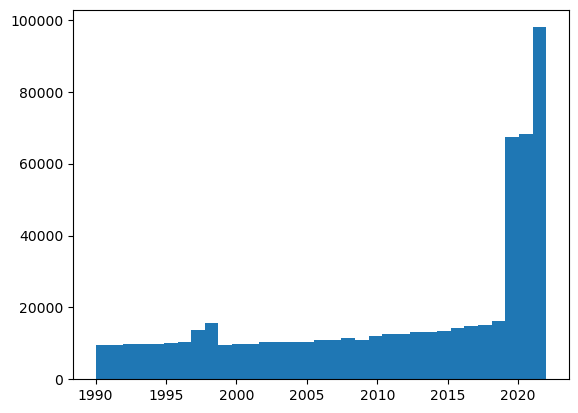

In [51]:
#Load in full data and see how much overlap there is
old_df = pd.read_excel('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/old_agstats/IN_AgStatsFeb2025_Gary.xlsx') 
bin_num_old = np.max(old_df['Year']) - np.min(old_df['Year']) + 1
plt.hist(old_df['Year'], bins=bin_num_old)

In [52]:
new_df = pd.read_csv('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_071925.csv')

In [53]:
old_df[old_df['Year'] >= 2019]['Quantity Produced: MT'].value_counts()

Quantity Produced: MT
0.00        191588
1.00          1418
2.00          1073
3.00           824
4.00           684
             ...  
2.06             1
1.35             1
17651.94         1
14508.70         1
28.26            1
Name: count, Length: 19607, dtype: int64

In [54]:
new_df[new_df['Year'] >= 2019]['Quantity Produced: MT'].value_counts()

Quantity Produced: MT
1.0         1500
2.0         1044
3.0          834
4.0          681
6.0          586
            ... 
176557.0       1
11017.0        1
16651.0        1
12044.0        1
8125.0         1
Name: count, Length: 22826, dtype: int64

(array([ 8431., 11181., 11808., 12225., 11982., 12746., 13120., 12782.,
        12797., 13246., 13345., 13889., 14070., 13650., 14822., 14037.,
        14912., 14355., 14966., 15986., 16488., 16817., 17601., 17039.,
        16701., 16993.]),
 array([1997.        , 1997.96153846, 1998.92307692, 1999.88461538,
        2000.84615385, 2001.80769231, 2002.76923077, 2003.73076923,
        2004.69230769, 2005.65384615, 2006.61538462, 2007.57692308,
        2008.53846154, 2009.5       , 2010.46153846, 2011.42307692,
        2012.38461538, 2013.34615385, 2014.30769231, 2015.26923077,
        2016.23076923, 2017.19230769, 2018.15384615, 2019.11538462,
        2020.07692308, 2021.03846154, 2022.        ]),
 <BarContainer object of 26 artists>)

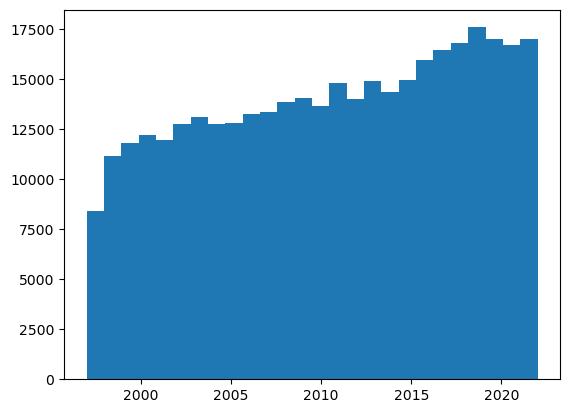

In [55]:
bin_num = np.max(new_df['Year']) - np.min(new_df['Year']) + 1
plt.hist(new_df['Year'], bins=bin_num)

In [56]:
new_names = new_df[new_df['Year'] == 2022]['Admin 2'].unique().astype(str)
old_names = old_df[old_df['Year'] == 2022]['Admin 2'].unique().astype(str)

In [57]:
unique_names = new_names[~np.isin(new_names,old_names)]

In [58]:
np.sort(new_names)

array(['Adilabad (TG)', 'Agar Malwa (MP)', 'Agra (UP)', 'Ahmedabad (GJ)',
       'Ahmednagar (MH)', 'Aizawl (MZ)', 'Ajmer (RJ)', 'Akola (MH)',
       'Alappuzha (KL)', 'Aligarh (UP)', 'Alipurduar (WB)',
       'Alirajpur (MP)', 'Alluri Sitharama Raju (AP)', 'Almora (UK)',
       'Alwar (RJ)', 'Ambala (HR)', 'Ambedkar Nagar (UP)', 'Amethi (UP)',
       'Amravati (MH)', 'Amreli (GJ)', 'Amritsar (PB)', 'Amroha (UP)',
       'Anakapalli (AP)', 'Anand (GJ)', 'Anantapur (AP)', 'Anantnag (JK)',
       'Angul (OD)', 'Anjaw (AR)', 'Annamayya (AP)', 'Anuppur (MP)',
       'Araria (BR)', 'Aravalli (GJ)', 'Ariyalur (TN)', 'Arwal (BR)',
       'Ashoknagar (MP)', 'Auraiya (UP)', 'Aurangabad (BR)',
       'Aurangabad (MH)', 'Ayodhya (UP)', 'Azamgarh (UP)',
       'Bagalkot (KA)', 'Bageshwar (UK)', 'Bagpat (UP)', 'Bahraich (UP)',
       'Baksa (AS)', 'Balaghat (MP)', 'Balangir (OD)', 'Balasore (OD)',
       'Ballari (KA)', 'Ballia (UP)', 'Balod (CG)', 'Baloda Bazar (CG)',
       'Balrampur (UP)', 'Bal

In [59]:
len(new_names)

738

In [60]:
np.sort(old_names)

array(['Adilabad (TG)', 'Agar Malwa (MP)', 'Agra (UP)', 'Ahmedabad (GJ)',
       'Ahmednagar (MH)', 'Aizawl (MZ)', 'Ajmer (RJ)', 'Akola (MH)',
       'Alappuzha (KL)', 'Aligarh (UP)', 'Alipurduar (WB)',
       'Alirajpur (MP)', 'Alluri Sitharama Raju (AP)', 'Almora (UK)',
       'Alwar (RJ)', 'Ambala (HR)', 'Ambedkar Nagar (UP)', 'Amethi (UP)',
       'Amravati (MH)', 'Amreli (GJ)', 'Amritsar (PB)', 'Amroha (UP)',
       'Anakapalli (AP)', 'Anand (GJ)', 'Anantapur (AP)', 'Anantnag (JK)',
       'Angul (OD)', 'Anjaw (AR)', 'Annamayya (AP)', 'Anuppur (MP)',
       'Araria (BR)', 'Aravalli (GJ)', 'Ariyalur (TN)', 'Arwal (BR)',
       'Ashoknagar (MP)', 'Auraiya (UP)', 'Aurangabad (BR)',
       'Aurangabad (MH)', 'Ayodhya (UP)', 'Azamgarh (UP)',
       'Bagalkot (KA)', 'Bageshwar (UK)', 'Bagpat (UP)', 'Bahraich (UP)',
       'Baksa (AS)', 'Balaghat (MP)', 'Balangir (OD)', 'Balasore (OD)',
       'Ballari (KA)', 'Ballia (UP)', 'Balod (CG)', 'Baloda Bazar (CG)',
       'Balrampur (UP)', 'Bal

In [61]:
unique_names

array(['Charkhi Dadri (HR)', 'Puducherry (PY)', 'Kamrup (AS)',
       'Warangal (TG)', 'Warangal Urban (TG)',
       'Dadra And Nagar Haveli (DD)', 'Kanpur Nagar (UP)',
       'North Twenty-Four Paraganas (WB)',
       'South Twenty-Four Paraganas (WB)', 'Saiha (MZ)'], dtype='<U32')

In [62]:

old = np.array([ 18961.,  19569.,   9881.,  20457.,  13681.,  25088.,  19687., 10267.,  20766.,  10404.,  21894.,  22318.,  11975.,  25245., 13112.,  26452.,  29171.,  14995.,  83583., 166302.])
new = np.array([ 18955.,  19560.,   9878.,  20439.,  18711.,  38241.,  33003., 17288.,  35129.,  17371.,  35889.,  37183.,  18605.,  38082., 19754.,  38798.,  43451.,  22427.,  98756., 179524.])

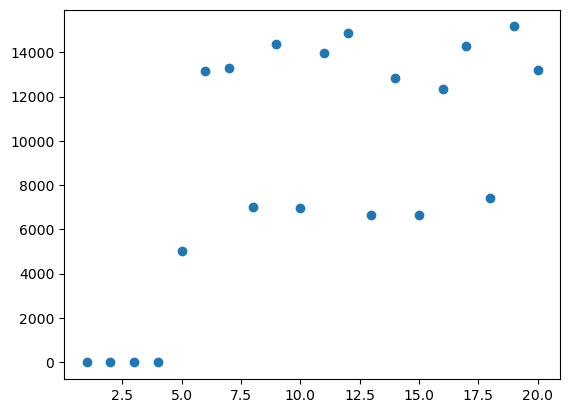

In [63]:
#Ask Gary what might be going on here
plt.scatter(np.linspace(1, len(new - old), len(new - old)), new - old)

In [64]:
np.sum(new - old)

np.float64(177236.0)